# 1. End-to-end model: CT scans latent features + Tabular features
This model is a simple end-to-end solution that uses CT scans latent features and tabular features to generate predictions.

The CT scans latent features are obtained by encoding pre-processed 3D CT scan tensors, using a pre-trained AutoEncoder for that. 

The tabular features are obtained by pre-processing the tabular data (more about it [here](https://www.kaggle.com/carlossouza/quantile-regression-pytorch-tabular-data-only)).

I am not including here the code used to train the AutoEncoder. I pretrained it in another notebook, and saved the weights in a [public dataset](https://www.kaggle.com/carlossouza/osicautoencoder).

The overal model looks like the image below:
![image](https://i.ibb.co/N65VVMp/final-5f18d00d86a6870013068112-270220.gif)

This version runs on CPU, end-to-end. However, it is slow. Improvements/next steps at the end.

# 2. Imports and global variables

In [1]:
use_TPU = False

In [2]:
if use_TPU:
    !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
    !python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

In [3]:
if use_TPU:
    import torch_xla
    import torch_xla.debug.metrics as met
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.utils.utils as xu
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.xla_multiprocessing as xmp
    import torch_xla.test.test_utils as test_utils

    import warnings
    warnings.filterwarnings("ignore")

In [4]:
if use_TPU:
    !export XLA_USE_BF16=1

In [5]:
import copy
import os
import glob as gb
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import pydicom
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from torch.utils.data import Dataset
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
from time import time
import warnings
from scipy.ndimage.interpolation import zoom
from enum import Enum
from torchvision import transforms
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
import pytest

In [6]:
root_dir = Path('/kaggle/input/osic-pulmonary-fibrosis-progression')
model_dir = Path('/kaggle/working')
### how to get this pretrained weights?
pretrained_weigths_dir = Path('/kaggle/input/osicautoencoder')
pretrained_ae_weigths = pretrained_weigths_dir/'barcelona-20200722.pth'
cache_dir = Path('/kaggle/input/osic-cached-dataset')
latent_dir = Path('/kaggle/working/latent')
latent_dir.mkdir(exist_ok=True, parents=True)
# num_kfolds = 5
test_size=0.2
batch_size = 32
learning_rate = 1e-3
num_epochs = 50
quantiles = (0.2, 0.5, 0.8)
model_name ='cauchy'

if use_TPU:
    device = xm.xla_device()
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
pwd

'/kaggle/working'

# 3. Dataset interface
Now, the dataset interface not only ingests the tabular data, but also ingests and pre-process the 3D CT scans. The changes vs. [the baseline notebook](https://www.kaggle.com/carlossouza/quantile-regression-pytorch-tabular-data-only) are highlighted in the code.

On the code below, again credits to [Ulrich GOUE](https://www.kaggle.com/ulrich07).

The key trick here is to cache all tensors in disk, otherwise training will become extremely slow, as the bottleneck will become the DataLoader. That's because, without caching, every time ClinicalDataset is queried, it will re-preprocess and re-create 3D images from scratch. The solution below solves the problem. For perspective, without caching, loading a single sample takes ~1.5 seconds. With caching, ~6 millisencods.

Another solution would be just hold all 3D images on CPU memory, as they require approx 3.7 GB with the parameters I used in preprocessing pipeline, and transfer them to GPU/TPU when needed. May be even faster. I will experiment with that later.

In [8]:
class ClinicalDataset(Dataset):
    def __init__(self, root_dir, ctscans_dir, mode,transform=None,
                 cache_dir=None):
        self.transform = transform
        self.mode = mode #train, val or test
        self.ctscans_dir = Path(ctscans_dir)
        self.cache_dir = None if cache_dir is None else Path(cache_dir)

        # If cache_dir is set, use cached values...
        if cache_dir is not None:
            self.raw = pd.read_csv(self.cache_dir/f'tabular_{mode}.csv')
            with open(self.cache_dir/'features_list.pkl', "rb") as fp:
                self.FE = pickle.load(fp)
            return

        # ...otherwise, pre-process
        tr = pd.read_csv(Path(root_dir)/"train.csv")
        tr.drop_duplicates(keep=False, inplace=True, subset=['Patient', 'Weeks'])
        chunk = pd.read_csv(Path(root_dir)/"test.csv")

        sub = pd.read_csv(Path(root_dir)/"sample_submission.csv")
        sub['Patient'] = sub['Patient_Week'].apply(lambda x: x.split('_')[0])
        sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
        sub = sub[['Patient', 'Weeks', 'Confidence', 'Patient_Week']]
        sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

        tr['WHERE'] = 'train'
        chunk['WHERE'] = 'val'
        sub['WHERE'] = 'test'
        data = tr.append([chunk, sub])

        data['min_week'] = data['Weeks']
        data.loc[data.WHERE == 'test', 'min_week'] = np.nan
        data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

        base = data.loc[data.Weeks == data.min_week]
        base = base[['Patient', 'FVC']].copy()
        base.columns = ['Patient', 'min_FVC']
        base['nb'] = 1
        base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
        base = base[base.nb == 1]
        base.drop('nb', axis=1, inplace=True)

        data = data.merge(base, on='Patient', how='left')
        data['base_week'] = data['Weeks'] - data['min_week']
        del base

        COLS = ['Sex', 'SmokingStatus']
        self.FE = []
        for col in COLS:
            for mod in data[col].unique():
                self.FE.append(mod)
                data[mod] = (data[col] == mod).astype(int)

        data['age'] = (data['Age'] - data['Age'].min()) / \
                      (data['Age'].max() - data['Age'].min())
        data['BASE'] = (data['min_FVC'] - data['min_FVC'].min()) / \
                       (data['min_FVC'].max() - data['min_FVC'].min())
        data['week'] = (data['base_week'] - data['base_week'].min()) / \
                       (data['base_week'].max() - data['base_week'].min())
        data['percent'] = (data['Percent'] - data['Percent'].min()) / \
                          (data['Percent'].max() - data['Percent'].min())
        self.FE += ['age', 'percent', 'week', 'BASE']
        # we have 9 features in total

        self.raw = data.loc[data.WHERE == mode].reset_index() # processed tubular data
        del data

    def __len__(self):
        return len(self.raw)

    def __getitem__(self, idx): 
        # __getitem__ is similar as set[key] and return 
        if torch.is_tensor(idx):
            idx = idx.tolist()

        patient_id = self.raw['Patient'].iloc[idx]
        if self.cache_dir is None:
            patient_path = self.ctscans_dir / patient_id
            image, metadata = load_scan(patient_path)
        else:
            image = torch.load(self.cache_dir / f'{patient_id}.pt')
            metadata = pydicom.read_file(self.cache_dir / f'{patient_id}.dcm')

        sample = {
            'features': self.raw[self.FE].iloc[idx].values,
            'image': image,
            'metadata': metadata,
            'target': self.raw['FVC'].iloc[idx]
        }
        if self.transform:
            sample = self.transform(sample)

        return sample

    def cache(self, cache_dir):
        # this part is not necessary since all the cached data are already prepared in the input
        Path(cache_dir).mkdir(exist_ok=True, parents=True)

        # Cache raw features table
        self.raw.to_csv(Path(cache_dir)/f'tabular_{self.mode}.csv', index=False)

        # Cache features list
        with open(Path(cache_dir)/'features_list.pkl', "wb") as fp:
            pickle.dump(self.FE, fp)

        # Cache images and metadata
        self.raw['index'] = self.raw.index
        idx_unique = self.raw.groupby('Patient').first()['index'].values
        bar = tqdm(idx_unique.tolist())
        for idx in bar:
            sample = self[idx]
            patient_id = sample['metadata'].PatientID
            torch.save(sample['image'], Path(cache_dir)/f'{patient_id}.pt')
            sample['metadata'].save_as(Path(cache_dir)/f'{patient_id}.dcm')

In [9]:
# generate files missing in the cache folder
import os
if os.path.isfile(cache_dir/'features_list.pkl'): 
    # if this file exists, it means you are using the modified cached dataset that already has these missing files
    print('skip this step')

else:
    data_test = ClinicalDataset(
        root_dir=root_dir,
        ctscans_dir=root_dir/'test',
        mode='val',
        transform=transforms.Compose([
            CropBoundingBox(),
            ConvertToHU(),
            Resize((40, 256, 256)),
            Clip(bounds=(-1000, 500)),
            Mask(method=MaskMethod.MORPHOLOGICAL, threshold=-500),
            Normalize(bounds=(-1000, -500))
        ]))
    data_train = ClinicalDataset(
        root_dir=root_dir,
        ctscans_dir=root_dir/'train',
        mode='train',
        transform=transforms.Compose([
            CropBoundingBox(),
            ConvertToHU(),
            Resize((40, 256, 256)),
            Clip(bounds=(-1000, 500)),
            Mask(method=MaskMethod.MORPHOLOGICAL, threshold=-500),
            Normalize(bounds=(-1000, -500))
        ]))

    data_test.raw.to_csv(Path(f'tabular_{data_test.mode}.csv'), index=False)
    data_train.raw.to_csv(Path(f'tabular_{data_train.mode}.csv'), index=False)
    with open(Path('features_list.pkl'), "wb") as fp:
                pickle.dump(data_test.FE, fp)
    
    data_train.raw['index'] = data_train.raw.index
    idx_unique = data_train.raw.groupby('Patient').first()['index'].values
    bar = tqdm(idx_unique.tolist())
    for idx in bar:
        sample = data_train[idx]
        patient_id = sample['metadata'].PatientID
        torch.save(sample['image'], Path(f'{patient_id}.pt'))
        sample['metadata'].save_as(Path(f'{patient_id}.dcm'))
        
    data_test.raw['index'] = data_test.raw.index
    idx_unique = data_test.raw.groupby('Patient').first()['index'].values
    bar = tqdm(idx_unique.tolist())
    for idx in bar:
        sample = data_train[idx]
        patient_id = sample['metadata'].PatientID
        torch.save(sample['image'], Path(f'{patient_id}.pt'))
        sample['metadata'].save_as(Path(f'{patient_id}.dcm'))
    


skip this step


In [10]:
# Helper function that loads CT scans in a single array. 
# This is also new vs. baselie
def load_scan(path):
    slices = [pydicom.read_file(p) for p in path.glob('*.dcm')]
    try:
        slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    except AttributeError:
        warnings.warn(f'Patient {slices[0].PatientID} CT scan does not '
                      f'have "ImagePositionPatient". Assuming filenames '
                      f'in the right scan order.')

    image = np.stack([s.pixel_array.astype(float) for s in slices])
    return image, slices[0]

## 3.1. Preprocessing CT Scans

This section is new vs. the baseline notebook. It builds on a lot of great work done by several Kagglers (I'll make an effort and cite everyone).

### 3.1.1. Crop bounding boxes

In [11]:
class CropBoundingBox:
    @staticmethod # so that bounding_box doesn't need to have an argument as self
    def bounding_box(img3d: np.array):
        mid_img = img3d[int(img3d.shape[0] / 2)]
        same_first_row = (mid_img[0, :] == mid_img[0, 0]).all()
        same_first_col = (mid_img[:, 0] == mid_img[0, 0]).all()
        if same_first_col and same_first_row:
            return True
        else:
            return False

    def __call__(self, sample):
        image = sample['image']
        if not self.bounding_box(image):
            return sample

        mid_img = image[int(image.shape[0] / 2)]
        r_min, r_max = None, None
        c_min, c_max = None, None
        for row in range(mid_img.shape[0]):
            if not (mid_img[row, :] == mid_img[0, 0]).all() and r_min is None:
                r_min = row
            if (mid_img[row, :] == mid_img[0, 0]).all() and r_max is None \
                    and r_min is not None:
                r_max = row
                break

        for col in range(mid_img.shape[1]):
            if not (mid_img[:, col] == mid_img[0, 0]).all() and c_min is None:
                c_min = col
            if (mid_img[:, col] == mid_img[0, 0]).all() and c_max is None \
                    and c_min is not None:
                c_max = col
                break

        image = image[:, r_min:r_max, c_min:c_max]
        return {
            'features': sample['features'],
            'image': image,
            'metadata': sample['metadata'],
            'target': sample['target']
        }

### 3.1.2. Convert to Hounsfield Units
Getting to the code below was really painful. Credits to lots of people.

In [12]:
class ConvertToHU:
    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']

        img_type = data.ImageType
        is_hu = img_type[0] == 'ORIGINAL' and not (img_type[2] == 'LOCALIZER')
        if not is_hu:
            warnings.warn(f'Patient {data.PatientID} CT Scan not cannot be'
                          f'converted to Hounsfield Units (HU).')

        intercept = data.RescaleIntercept
        slope = data.RescaleSlope
        image = (image * slope + intercept).astype(np.int16)
        return {
            'features': sample['features'],
            'image': image,
            'metadata': data,
            'target': sample['target']
        }

### 3.1.3. Resize

In [13]:
class Resize:
    def __init__(self, output_size):
        assert isinstance(output_size, tuple)
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']
        resize_factor = np.array(self.output_size) / np.array(image.shape)
        image = zoom(image, resize_factor, mode='nearest')
        return {
            'features': sample['features'],
            'image': image,
            'metadata': sample['metadata'],
            'target': sample['target']
        }

### 3.1.4. Clip

In [14]:
class Clip:
    def __init__(self, bounds=(-1000, 500)):
        self.min = min(bounds)
        self.max = max(bounds)

    def __call__(self, sample):
        image = sample['image']
        image[image < self.min] = self.min
        image[image > self.max] = self.max
        return {
            'features': sample['features'],
            'image': image,
            'metadata': sample['metadata'],
            'target': sample['target']
        }

### 3.1.5 Mask
Here I basically tried 2 different methods: one [morphological](https://www.kaggle.com/miklgr500/unsupervise-lung-detection), and one using [Deep Learning](https://github.com/JoHof/lungmask). The deep learning method is extremely slow, so we go for the morphological path. The deep learning method is incomplete (thus the `raise NotImplementedError` in the code below). 

Credits to @[Michael Kazachok](https://www.kaggle.com/miklgr500).

In [15]:
class MaskMethod(Enum):
    MORPHOLOGICAL = 1
    DEEPLEARNING = 2


class Mask:
    def __init__(self, method=MaskMethod.MORPHOLOGICAL, threshold=-400,
                 root_dir='../data/test'):
        self.threshold = threshold
        self.method = method
        self.root_dir = root_dir

    def __call__(self, sample):
        image = sample['image']
        if self.method == MaskMethod.MORPHOLOGICAL:
            for slice_id in range(image.shape[0]):
                m = self.get_morphological_mask(image[slice_id])
                image[slice_id][m == False] = image[slice_id].min()
        elif self.method == MaskMethod.DEEPLEARNING:
            # m = self.get_deeplearning_mask(data.PatientID)
            raise NotImplementedError
        else:
            raise ValueError('Unrecognized masking method')

        return {
            'features': sample['features'],
            'image': image,
            'metadata': sample['metadata'],
            'target': sample['target']
        }

    def get_morphological_mask(self, image):
        m = image < self.threshold
        m = clear_border(m)
        m = label(m)
        areas = [r.area for r in regionprops(m)]
        areas.sort()
        if len(areas) > 2:
            for region in regionprops(m):
                if region.area < areas[-2]:
                    for coordinates in region.coords:
                        m[coordinates[0], coordinates[1]] = 0
        return m > 0

    def get_deeplearning_mask(self, patient_id):
        """Very slow, must be done using GPUs
        """
        list_files = [str(x) for x in (Path(self.root_dir) / patient_id).glob('*.dcm')]
        input_image = sitk.ReadImage(list_files)
        m = mask.apply(input_image) #.squeeze()
        m[m == 2] = 1
        return m

### 3.1.6. Normalize, to tensor and zero center

In [16]:
class Normalize:
    def __init__(self, bounds=(-1000, 500)):
        self.min = min(bounds)
        self.max = max(bounds)

    def __call__(self, sample):
        image = sample['image'].astype(np.float)
        image = (image - self.min) / (self.max - self.min)
        return {
            'features': sample['features'],
            'image': image,
            'metadata': sample['metadata'],
            'target': sample['target']
        }


class ToTensor:
    def __init__(self, add_channel=True):
        self.add_channel = add_channel

    def __call__(self, sample):
        image = sample['image']
        if self.add_channel:
            image = np.expand_dims(image, axis=0)

        return {
            'features': sample['features'],
            'image': torch.from_numpy(image),
            'metadata': sample['metadata'],
            'target': sample['target']
        }

    
class ZeroCenter:
    def __init__(self, pre_calculated_mean):
        self.pre_calculated_mean = pre_calculated_mean

    def __call__(self, sample):
        return {
            'features': sample['features'],
            'image': sample['image'] - self.pre_calculated_mean,
            'metadata': sample['metadata'],
            'target': sample['target']
        }

## 3.2. Checking the data pipeline
Before moving forward, let's ensure the data pipeline works

In [17]:
def show(list_imgs, cmap=cm.bone, rgb=False):
    list_slices = []
    for img3d in list_imgs:
        slc = int(img3d.shape[0] / 2)
        img = img3d[slc]
        if rgb:
            img = (img * 255).astype(np.int16)
        list_slices.append(img)
    
    fig, axs = plt.subplots(1, 5, figsize=(15, 7))
    for i, img in enumerate(list_slices):
        axs[i].imshow(img, cmap=cmap)
    
    plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Patient ID00421637202311550012437 CT Scan not cannot beconverted to Hounsfield Units (HU).
  


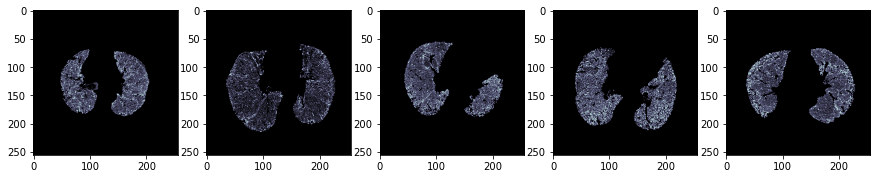

In [18]:
data = ClinicalDataset(
    root_dir=root_dir,
    ctscans_dir=root_dir/'test',
    mode='val',
    transform=transforms.Compose([
        CropBoundingBox(),
        ConvertToHU(),
        Resize((40, 256, 256)),
        Clip(bounds=(-1000, 500)),
        Mask(method=MaskMethod.MORPHOLOGICAL, threshold=-500),
        Normalize(bounds=(-1000, -500))
    ]))

for i in range(len(data)):
    assert data[i]['image'].shape == (40, 256, 256)
    
list_imgs = [data[i]['image'] for i in range(len(data))]
show(list_imgs)

In [19]:
print(data[1]['features'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Patient ID00421637202311550012437 CT Scan not cannot beconverted to Hounsfield Units (HU).
  


[1.         0.         1.         0.         0.         0.48717949
 0.42784787 0.17901235 0.32020802]


# 4. Models and loss
The differences vs. the baseline notebook are highlighted in the code.

## 4.1. Quant model

see https://medium.com/the-artificial-impostor/quantile-regression-part-1-e25bdd8d9d43
and 
https://medium.com/the-artificial-impostor/quantile-regression-part-2-6fdbc26b2629

Source code：
https://github.com/ceshine/quantile-regression-tensorflow

In [20]:
class QuantModel(nn.Module):
    def __init__(self, in_tabular_features=9, in_ctscan_features=76800,
                 out_quantiles=3):
        # nn.Module is parent class, QuantModel is child class,
        # with this super().__init__, QuantModel inherit things from nn.Module.
        super(QuantModel, self).__init__() 
    
        # This line is new. We need to know a priori the number
        # of latent features to properly flatten the tensor
        self.in_ctscan_features = in_ctscan_features

        self.fc1 = nn.Linear(in_tabular_features, 512)
        self.fc2 = nn.Linear(in_ctscan_features, 512)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, out_quantiles)
    
    # this is the real algorithm after all the layers are defined
    def forward(self, x1, x2):
        # Now the quant model has 2 inputs: x1 (the tabular features)
        # and x2 (the pre-computed latent features)
        x1 = F.relu(self.fc1(x1))
        
        # Flattens the latent features and concatenate with tabular features
        x2 = x2.view(-1, self.in_ctscan_features)
        x2 = F.relu(self.fc2(x2))
        x = torch.cat([x1, x2], dim=1)
        
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

## 4.2. Quant loss
No news here vs. baseline notebook. Again, credits to [Ceshine Lee's quantile regression tutorial](https://medium.com/the-artificial-impostor/quantile-regression-part-2-6fdbc26b2629).

In [21]:
def quantile_loss(preds, target, quantiles):
    assert not target.requires_grad
    assert preds.size(0) == target.size(0)
    losses = []
    for i, q in enumerate(quantiles):
        errors = target - preds[:, i]
        losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(1))
    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss

## 4.3. AutoEncoder
This is new vs. baseline notebook. As mentioned, the auto-encoder was pre-trained in another notebook. I won't include the pre-training code here otherwise this notebook will become even larger.

Credits to [Srinjay Paul's 3D Convolutional autoencoder for brain volumes tutorial](https://srinjaypaul.github.io/3D_Convolutional_autoencoder_for_brain_volumes/).

In [22]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.conv1 = nn.Conv3d(1, 16, 3) # (input channel,output channel, kernel_size)
        self.conv2 = nn.Conv3d(16, 32, 3)
        self.conv3 = nn.Conv3d(32, 96, 2)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.pool2 = nn.MaxPool3d(kernel_size=3, stride=3, return_indices=True)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        # Decoder
        self.deconv1 = nn.ConvTranspose3d(96, 32, 2)
        self.deconv2 = nn.ConvTranspose3d(32, 16, 3)
        self.deconv3 = nn.ConvTranspose3d(16, 1, 3)
        self.unpool1 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool2 = nn.MaxUnpool3d(kernel_size=3, stride=3)
        self.unpool3 = nn.MaxUnpool3d(kernel_size=2, stride=2)

    def encode(self, x, return_partials=True):
        # Encoder
        x = self.conv1(x)
        up3out_shape = x.shape
        x, i1 = self.pool1(x)
        x = self.conv2(x)
        up2out_shape = x.shape
        x, i2 = self.pool2(x)
        x = self.conv3(x)
        up1out_shape = x.shape
        x, i3 = self.pool3(x)

        if return_partials:
            return x, up3out_shape, i1, up2out_shape, i2, up1out_shape, i3
        else:
            return x

    def forward(self, x):
        x, up3out_shape, i1, up2out_shape, i2, up1out_shape, i3 = self.encode(x)

        # Decoder
        x = self.unpool1(x, output_size=up1out_shape, indices=i3)
        x = self.deconv1(x)
        x = self.unpool2(x, output_size=up2out_shape, indices=i2)
        x = self.deconv2(x)
        x = self.unpool3(x, output_size=up3out_shape, indices=i1)
        x = self.deconv3(x)

        return x

## 4.4. Cache all pre-processed 3D CT Scans and pre-compute all latent features
It takes ~15 minutes to pre-process all 3D CT scan. To accelerate, I already pre-cached the dataset and made it available in [this public dataset](https://www.kaggle.com/carlossouza/osic-cached-dataset). If you want to do it, the code to cache the dataset is `dataset.cache(cache_dir)`. 

With the dataset cached, let's pre-compute all latent features. (Not pre-computing them would lead to very slow training...):

In [23]:
# Helper function that generates all latent features
class GenerateLatentFeatures:
    def __init__(self, autoencoder, latent_dir):
        self.autoencoder = autoencoder
        self.latent_dir = Path(latent_dir)
        self.cache_dir = Path(cache_dir)

    def __call__(self, sample):
        patient_id = sample['metadata'].PatientID
        cached_latent_file = self.latent_dir/f'{patient_id}_lat.pt'

        if cached_latent_file.is_file():
            latent_features = torch.load(cached_latent_file)
        else:
            with torch.no_grad():
                img = sample['image'].float().unsqueeze(0)
                latent_features = self.autoencoder.encode(
                    img, return_partials=False).squeeze(0)
            torch.save(latent_features, cached_latent_file)

        return {
            'tabular_features': sample['features'],
            'latent_features': latent_features,
            'target': sample['target']
        }

The code below loops through all samples in the dataset, pre-computes the latent features, and cache them in disk as well.
This step is not necessary if latent features are already provided in the output.

In [24]:
total_patient_num = np.array(sorted(gb.glob(os.path.join(root_dir,'train', os.path.normpath('*'))))).shape[0]
if np.array(sorted(gb.glob(os.path.join('/kaggle/working/latent', os.path.normpath('*.pt'))))).shape[0] == total_patient_num:
    print('Already have latent features, skip this step!')
else:
    autoencoder = AutoEncoder()
    autoencoder.load_state_dict(torch.load(
        pretrained_ae_weigths,
        map_location=torch.device('cpu')
    ))
    autoencoder.to(device)
    autoencoder.eval()

    data = ClinicalDataset(
        root_dir=root_dir,
        ctscans_dir=root_dir/'train',
        cache_dir=cache_dir,
        mode='train',
        transform=GenerateLatentFeatures(autoencoder, latent_dir)
    )
    for i in trange(len(data)):
        sample = data[i]
        assert sample['latent_features'].shape == (96, 2, 20, 20)

100%|██████████| 1535/1535 [03:02<00:00,  8.43it/s]


## 4.5. Overfit a small batch before moving forward (can skip)
As observed by Andrej Karpathy ([A Recipe for Training Neural Networks](http://karpathy.github.io/2019/04/25/recipe/)), neural net training fail silently. Before moving to full blown training, let's overfit a small batch: if we observe the loss decreasing, it is a sign that we probably did not make any obvious mistakes so far.

In [25]:
# dataloader = DataLoader(data, batch_size=batch_size,
#                         shuffle=True, num_workers=2)
# batch = next(iter(dataloader))

# model = QuantModel().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# bar = trange(50)
# for epoch in bar:
#     inputs1 = batch['tabular_features'].float().to(device)
#     inputs2 = batch['latent_features'].float().to(device)
#     targets = batch['target'].to(device)

#     optimizer.zero_grad()
#     preds = model(inputs1, inputs2)
#     loss = quantile_loss(preds, targets, quantiles)
#     loss.backward()
#     if use_TPU:
#         xm.optimizer_step(optimizer, barrier=True)
#     else:
#         optimizer.step()
    

#     bar.set_postfix(loss=f'{loss.item():0.1f}')

# 5. Training
I made 2 main changes here:
1. Code is adjusted to run on TPU. It is not optimized (uses only 1 of the 8 cores), but does the job... Anyway, the last version does everything on CPU
2. It is NOT doing Kfold CV. Code is back to doing simple Group Shuffle split. Main reason is that I did not see noticeable improvement from doing a simple split vs. KFold. When we were only using tabular data, no problem doing 5 folds. Now, every fold takes some time. As next step, an idea would be run every fold in parallel, in one of the 8 TPU cores, as I saw in one of the TPU tutorials. But that's for later

In [26]:
# Helper generator that group splits
def group_split(dataset, groups, test_size=0.2):
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size)
    idx = list(gss.split(dataset.raw, dataset.raw, groups))
    train = Subset(dataset, idx[0][0])
    val = Subset(dataset, idx[0][1])
    return train, val
        
# Helper function with competition metric
def metric(preds, targets):
    sigma = preds[:, 2] - preds[:, 0]
    sigma[sigma < 70] = 70
    delta = (preds[:, 1] - targets).abs()
    delta[delta > 1000] = 1000
    return -np.sqrt(2) * delta / sigma - torch.log(np.sqrt(2) * sigma)

In [27]:
# Load the data
print(num_epochs
     )
autoencoder = AutoEncoder()
autoencoder.load_state_dict(torch.load(
    pretrained_ae_weigths,
    map_location=torch.device('cpu')
))
autoencoder.eval()

data = ClinicalDataset(
    root_dir=root_dir,
    ctscans_dir=root_dir/'train',
    cache_dir=cache_dir,
    mode='train',
    transform=GenerateLatentFeatures(autoencoder, latent_dir)
)

trainset, valset = group_split(data, data.raw['Patient'], test_size)
t0 = time()

# Prepare to save model weights
Path(model_dir).mkdir(parents=True, exist_ok=True)
now = datetime.now()
fname = f'{model_name}-{now.year}{now.month:02d}{now.day:02d}.pth'
model_file = Path(model_dir) / fname

dataset_sizes = {'train': len(trainset), 'val': len(valset)}
dataloaders = {
    'train': DataLoader(trainset, batch_size=batch_size,
                        shuffle=True, num_workers=2),
    'val': DataLoader(valset, batch_size=batch_size,
                      shuffle=False, num_workers=2)
}

# Create the model and optimizer
model = QuantModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Set global tracking variables
epoch_loss = {'train': np.inf, 'val': np.inf}
epoch_metric = {'train': -np.inf, 'val': -np.inf}
best_loss = np.inf
best_model_wts = None
df = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss'])

# Training loop
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_metric = 0.0

        # Iterate over data
        num_samples = 0
        bar = tqdm(dataloaders[phase])
        for batch in bar:
            bar.set_description(f'Epoch {epoch} {phase}'.ljust(20))
            inputs1 = batch['tabular_features'].float().to(device)
            inputs2 = batch['latent_features'].float().to(device)
            targets = batch['target'].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            # track gradients if only in train
            with torch.set_grad_enabled(phase == 'train'):
                preds = model(inputs1, inputs2)
                loss = quantile_loss(preds, targets, quantiles)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    if use_TPU:
                        xm.optimizer_step(optimizer, barrier=True)
                    else:
                        optimizer.step()

            running_loss += loss.item() * inputs1.size(0)
            running_metric += metric(preds, targets).sum()

            # batch statistics
            num_samples += inputs1.size(0)
            bar.set_postfix(loss=f'{running_loss / num_samples:0.1f}',
                            metric=f'{running_metric / num_samples:0.4f}')

        # epoch statistics
        epoch_loss[phase] = running_loss / dataset_sizes[phase]
        epoch_metric[phase] = running_metric / dataset_sizes[phase]

        # deep copy the model
        if phase == 'val' and epoch_loss['val'] < best_loss:
            best_loss = epoch_loss['val']
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, model_file)

    df = df.append({
        'epoch': epoch + 1,
        'train_loss': epoch_loss["train"],
        'val_loss': epoch_loss["val"]
    }, ignore_index=True)

# Save training statistics
fname = f'{model_name}-{now.year}{now.month:02d}{now.day:02d}.csv'
csv_file = Path(model_dir) / fname
df.to_csv(csv_file, index=False)

# load best model weights
model.load_state_dict(best_model_wts)

print(f'Training complete! Time: {timedelta(seconds=time() - t0)}')
models = [model]

50


Epoch 49 val        : 100%|██████████| 10/10 [00:03<00:00,  2.98it/s, loss=672.1, metric=-8.8659]


Training complete! Time: 0:25:09.249336


# 6. Generating submission CSV
No change vs. baseline notebook

In [28]:
data = ClinicalDataset(
    root_dir=root_dir,
    ctscans_dir=root_dir/'test',
    mode='test',
    transform=transforms.Compose([
        CropBoundingBox(),
        ConvertToHU(),
        Resize((40, 256, 256)),
        Clip(bounds=(-1000, 500)),
        Mask(method=MaskMethod.MORPHOLOGICAL, threshold=-500),
        Normalize(bounds=(-1000, -500)),
        ToTensor(),
        ZeroCenter(pre_calculated_mean=0.029105728564346046)
    ]))

data.cache(latent_dir)

 20%|██        | 1/5 [00:02<00:09,  2.39s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Patient ID00421637202311550012437 CT Scan not cannot beconverted to Hounsfield Units (HU).
  
100%|██████████| 5/5 [00:49<00:00,  9.99s/it]


In [29]:
data = ClinicalDataset(
    root_dir=root_dir,
    ctscans_dir=root_dir/'test',
    cache_dir=latent_dir,
    mode='test',
    transform=GenerateLatentFeatures(autoencoder, latent_dir)
)

avg_preds = np.zeros((len(data), len(quantiles)))

for model in models:
    dataloader = DataLoader(data, batch_size=batch_size,
                            shuffle=False, num_workers=2)
    preds = []
    for batch in tqdm(dataloader):
        inputs1 = batch['tabular_features'].float()
        inputs2 = batch['latent_features'].float()
        with torch.no_grad():
            preds.append(model(inputs1, inputs2))

    preds = torch.cat(preds, dim=0).numpy()
    avg_preds += preds

avg_preds /= len(models)
df = pd.DataFrame(data=avg_preds, columns=list(quantiles))
df['Patient_Week'] = data.raw['Patient_Week']
df['FVC'] = df[quantiles[1]]
df['Confidence'] = df[quantiles[2]] - df[quantiles[0]]
df = df.drop(columns=list(quantiles))
df.to_csv('submission.csv', index=False)

100%|██████████| 23/23 [00:04<00:00,  5.34it/s]


In [30]:
print(len(df))
df.head()

730


,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2673.832031,221.181152
1,ID00419637202311204720264_-11,2671.075195,221.063965
2,ID00419637202311204720264_-10,2668.273438,220.946777
3,ID00419637202311204720264_-9,2665.459473,220.828857
4,ID00419637202311204720264_-8,2662.645752,220.711670


# 7. Conclusions and next steps
- The process is working, end-to-end
- However, it is very slow... need to figure out how to accelerate
- Need to experiment/tune hyperparameters to improve metric
- The final steps are very ugly, should refactor